# Analyze Experiment Results

In [16]:
import pickle
import os
import sys

# include parent directory in path
parent_dir = os.path.abspath('../..')
sys.path.append(parent_dir)

if os.path.exists('clients.pkl'):
    with open('clients.pkl', 'rb') as file:
        clients = pickle.load(file)
else:
    print('No clients found')


In [17]:
# imports
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
import pandas as pd


In [18]:
# load the metadata

# Initialize an empty dictionary to store the file content
metadata = {}

# Open the file and read line by line
with open('metadata.txt', 'r') as file:
    for line in file:
        # Strip white space and split by colon
        key, value = line.strip().split(': ')
        # Convert numerical values from strings
        if value.replace('.', '', 1).isdigit():
            if '.' in value:
                value = float(value)
            else:
                value = int(value)
        # Add to dictionary
        metadata[key] = value

# Print the dictionary
for key, value in metadata.items():
    if key == 'runtime':
        print(key, value/3600, 'hours')
    else:
        print(key, value)



gpu 0
nbr_rounds 100
nbr_clients 100
n_data_train 400
n_data_val 100
seed 1
batch_size 8
nbr_local_epochs 3
lr 3e-05
nbr_classes 10
nbr_channels 3
stopping_rounds 50
nbr_neighbors_sampled 5
prior_update_rule softmax
similarity_metric inverse_training_loss
cosine_alpha 0.5
tau 1
client_information_exchange DAC
experiment_name dev
delusion 0


In [19]:
# recreate the command used to run the experiment from the metadata
command = 'python3 run_experiment.py'
for key, value in metadata.items():
    command += f' --{key} {value}'
print(command)

python3 run_experiment.py --gpu 0 --nbr_rounds 100 --nbr_clients 100 --n_data_train 400 --n_data_val 100 --seed 1 --batch_size 8 --nbr_local_epochs 3 --lr 3e-05 --nbr_classes 10 --nbr_channels 3 --stopping_rounds 50 --nbr_neighbors_sampled 5 --prior_update_rule softmax --similarity_metric inverse_training_loss --cosine_alpha 0.5 --tau 1 --client_information_exchange DAC --experiment_name dev --delusion 0


### True similarities

In [ ]:
if 'measure_all_similarities' in metadata and metadata['measure_all_similarities']:
    client = clients[0]
    sims = client.true_similarities
    # sims is list of np arrays. Each array are similarities of a current time step
    # plot over time
    sims = np.array(sims)
    # the first 25 clients should be the same color
    for i in range(25):
        idx = i
        plt.plot(sims[:, idx], label=f'Client {idx}')
    plt.legend()

    plt.xlabel('Time step')
    plt.ylabel('Similarity')
    plt.title('Similarity over time')
    plt.show()



### Similarities over time

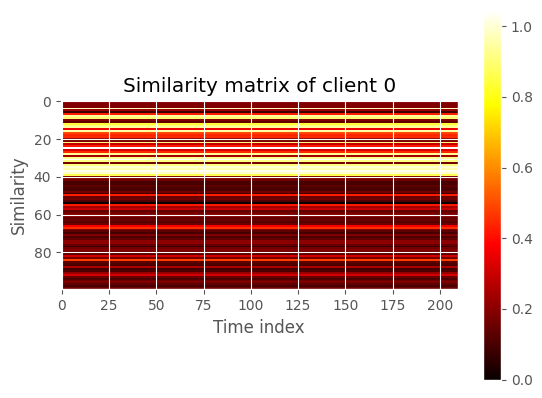

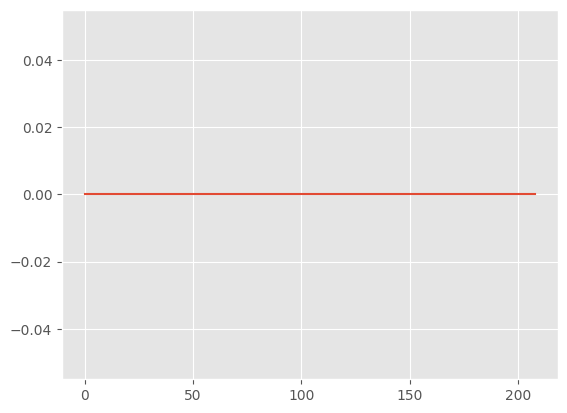

In [37]:
if metadata['client_information_exchange'] == 'DAC' or metadata['client_information_exchange'] == 'PANM':   
    # plot the similarities of client 0 with a heapmap, with the x-axis being the time index and the y-axis being the similarity
    similarity_matrix = clients[0].all_similarities
    plt.imshow(similarity_matrix, cmap='hot', interpolation='nearest')
    plt.imshow(np.transpose(similarity_matrix), cmap='hot', interpolation='nearest')

    # add colorbar
    plt.colorbar()

    # add labels
    plt.xlabel('Time index')
    plt.ylabel('Similarity')

    # add title
    plt.title('Similarity matrix of client 0')

    # now plot the euclidean distance of two consecutive similarities in a new plot
    # convert similarity matrix to numpy array
    similarity_matrix = np.array(similarity_matrix)
    # transpose the matrix
    similarity_matrix = np.transpose(similarity_matrix)
    euclidean_distances = np.linalg.norm(similarity_matrix[:, 1:] - similarity_matrix[:, :-1], axis=0)
    plt.figure()
    plt.plot(euclidean_distances)


### Who was sampled over time

In [38]:
if metadata['client_information_exchange'] == 'DAC' or metadata['client_information_exchange'] == 'PANM':       
    sampled_list = clients[0].exchanges_every_round

    # sampled_list is a list of lists of who was sampled in each round

    # plot who was sampled in each round, with round on the x-axis and client index on the y-axis
    plt.figure()
    plt.imshow(sampled_list, cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.xlabel('Round')
    plt.ylabel('Client index')
    plt.title('Sampled clients in each round')


AttributeError: 'Client' object has no attribute 'exchanges_every_round'

### Early Stopping

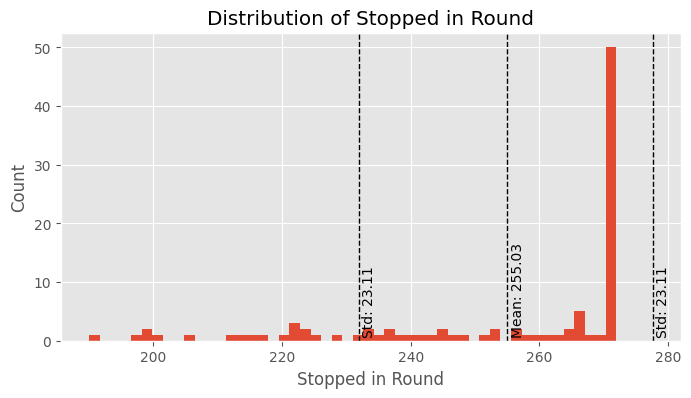

In [6]:
plt.figure(figsize=(8, 4))

stops = []
for client in clients:
    stops.append(len(client.val_acc_list))
plt.hist(stops, bins=50)
plt.xlabel('Stopped in Round')
plt.ylabel('Count')
plt.title('Distribution of Stopped in Round')

# plt mean and standard deviation
mean = np.mean(stops)
std = np.std(stops)
plt.axvline(mean, color='k', linestyle='dashed', linewidth=1)
plt.text(mean + .5, 1, 'Mean: {:.2f}'.format(mean), rotation=90)
plt.axvline(mean + std - .5, color='k', linestyle='dashed', linewidth=1)
plt.text(mean + std, 1, 'Std: {:.2f}'.format(std), rotation=90)
plt.axvline(mean - std, color='k', linestyle='dashed', linewidth=1)
plt.text(mean - std + .5, 1, 'Std: {:.2f}'.format(std), rotation=90)

plt.show()

### Validation Accuracy

In [7]:
# preprocess val acc lists - this is done such that for two accuracies plotted on the same index, POST EXCHANGE CAME FIRST

# pad each val_accs_post_exchange with two zeros in the beginning. One zero comes from the initial model validation without exchange and the other from the initial local training without exchange.
for client in clients:
    client.val_accs_post_exchange = [0] + client.val_accs_post_exchange

# now delete the end of each val_accs_post_exchange so that they are as long as val_acc_list for each client
for client in clients:
    client.val_accs_post_exchange = client.val_accs_post_exchange[:len(client.val_acc_list)]

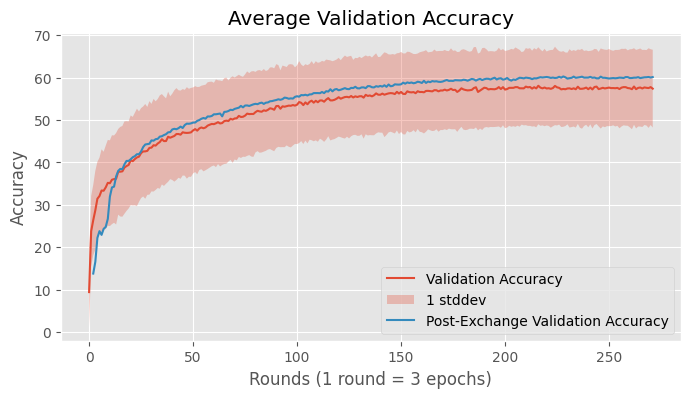

In [8]:
plt.figure(figsize=(8, 4))

# extend val_loss_list and val_accs_post_exchange for each client to be as long as the longest one
max_len = max([len(client.val_acc_list) for client in clients])
# pad end with last value
for client in clients:
    client.val_acc_list.extend([client.val_acc_list[-1]] * (max_len - len(client.val_acc_list)))
    client.val_accs_post_exchange.extend([client.val_accs_post_exchange[-1]] * (max_len - len(client.val_accs_post_exchange)))

avg_acc = np.mean([client.val_acc_list for client in clients], axis=0)
std_acc = np.std([client.val_acc_list for client in clients], axis=0)
plt.plot(avg_acc)
plt.fill_between(range(len(avg_acc)), avg_acc - std_acc, avg_acc + std_acc, alpha=0.3)

post_exchange_acc = np.mean([client.val_accs_post_exchange for client in clients], axis=0)

# plot post exchange accuracy, but dont display the first two values
plt.plot(range(1, len(post_exchange_acc)), post_exchange_acc[1:])

plt.xlabel('Rounds (1 round = {} epochs)'.format(metadata['nbr_local_epochs']))
plt.ylabel('Accuracy')
plt.title('Average Validation Accuracy')
plt.legend(['Validation Accuracy', '1 stddev','Post-Exchange Validation Accuracy'])


In [9]:
def plot_accuracy_per_group(group):
    plt.figure(figsize=(8, 4))

    avg_acc = np.mean([client.val_acc_list for client in clients if client.group == group], axis=0)
    std_acc = np.std([client.val_acc_list for client in clients if client.group == group], axis=0)
    plt.plot(avg_acc)
    plt.fill_between(range(len(avg_acc)), avg_acc - std_acc, avg_acc + std_acc, alpha=0.3)

    post_exchange_acc = np.mean([client.val_accs_post_exchange for client in clients if client.group == group], axis=0)

    # plot post exchange accuracy, but dont display the first two values
    plt.plot(range(1, len(post_exchange_acc)), post_exchange_acc[1:])

    plt.xlabel('Rounds')
    plt.ylabel('Accuracy')
    plt.title('Average Validation Accuracy for Group {}'.format(group))
    plt.legend(['Validation Accuracy', '1 stddev','Post-Exchange Validation Accuracy'])
    plt.ylim(0, 100)
    plt.show()

if metadata['dataset'] == 'cifar10':
    for i in range(2):
        plot_accuracy_per_group(i)
elif metadata['dataset'] == 'PACS':
    for i in range(4):
        plot_accuracy_per_group(i)


KeyError: 'dataset'

### Validation and Training Loss

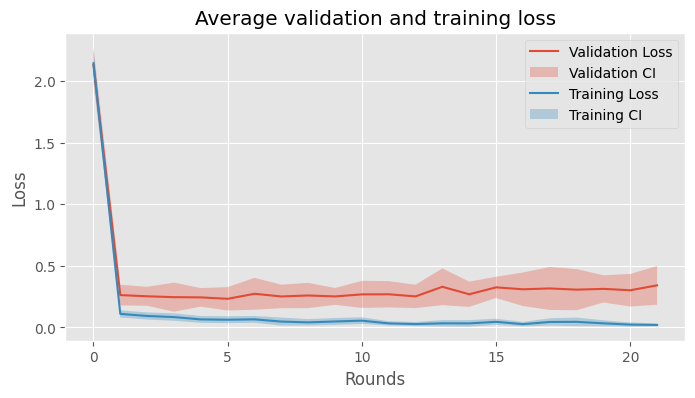

In [90]:
plt.figure(figsize=(8, 4))

# extend val_loss_list for each client to be as long as the longest one
max_len = max([len(client.val_loss_list) for client in clients])
# pad end with last value
for client in clients:
    client.val_loss_list.extend([client.val_loss_list[-1]] * (max_len - len(client.val_loss_list)))

# extend train_loss_list for each client to be as long as the longest one
max_len = max([len(client.train_loss_list) for client in clients])
# pad end with last value
for client in clients:
    client.train_loss_list.extend([client.train_loss_list[-1]] * (max_len - len(client.train_loss_list)))

avg_val_loss = np.mean([client.val_loss_list for client in clients], axis=0)
std_val_loss = np.std([client.val_loss_list for client in clients], axis=0)
plt.plot(avg_val_loss)
plt.fill_between(range(len(avg_val_loss)), avg_val_loss - std_val_loss, avg_val_loss + std_val_loss, alpha=0.3)
plt.xlabel('Rounds')
plt.ylabel('Loss')

avg_train_loss = np.mean([client.train_loss_list for client in clients], axis=0)
std_train_loss = np.std([client.train_loss_list for client in clients], axis=0)
plt.plot(avg_train_loss)
plt.fill_between(range(len(avg_train_loss)), avg_train_loss - std_train_loss, avg_train_loss + std_train_loss, alpha=0.3)

plt.title('Average validation and training loss')
plt.legend(['Validation Loss', 'Validation CI', 'Training Loss', 'Training CI'])
plt.show()

### Heatmaps

In [1]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Similarity heatmap
similarity_matrix = np.zeros((len(clients), len(clients)))
for i, client in enumerate(clients):
    similarity_matrix[i] = client.similarity_scores
im = axes[0].imshow(similarity_matrix, cmap='hot', interpolation='nearest')
axes[0].set_title('Similarity heatmap')
axes[0].set_xlabel('Clients')
axes[0].set_ylabel('Clients')
fig.colorbar(im, ax=axes[0])


# n_sampled heatmap
n_sampled_matrix = np.zeros((len(clients), len(clients)))
for i, client in enumerate(clients):
    n_sampled_matrix[i] = client.n_sampled
im = axes[1].imshow(n_sampled_matrix, cmap='hot', interpolation='nearest')
axes[1].set_title('n_sampled heatmap')
axes[1].set_xlabel('Clients')
axes[1].set_ylabel('Clients')
fig.colorbar(im, ax=axes[1])

# priors heatmap
priors_matrix = np.zeros((len(clients), len(clients)))
for i, client in enumerate(clients):
    priors_matrix[i] = client.priors
im = axes[2].imshow(priors_matrix, cmap='hot', interpolation='nearest')
axes[2].set_title('Priors heatmap')
axes[2].set_xlabel('Clients')
axes[2].set_ylabel('Clients')
fig.colorbar(im, ax=axes[2])

# turn off grid
for ax in axes:
    ax.grid(False)

plt.tight_layout()
plt.show()


NameError: name 'plt' is not defined

### Cluster-wise accuracies

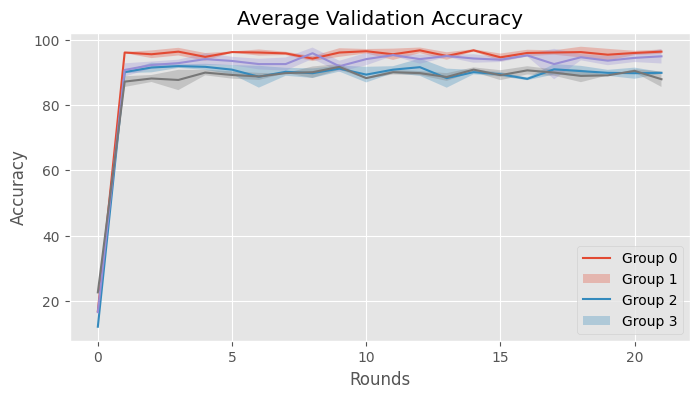

In [92]:
plt.figure(figsize=(8, 4))

if metadata['dataset'] == 'cifar10':
    nbr_groups = 2
elif metadata['dataset'] == 'PACS':
    nbr_groups = 4
    
for group in range(nbr_groups):
    avg_acc = np.mean([client.val_acc_list for client in clients if client.group == group], axis=0)
    std_acc = np.std([client.val_acc_list for client in clients if client.group == group], axis=0)
    plt.plot(avg_acc)
    plt.fill_between(range(len(avg_acc)), avg_acc - std_acc, avg_acc + std_acc, alpha=0.3)
    
plt.xlabel('Rounds')
plt.ylabel('Accuracy')
plt.title('Average Validation Accuracy')
plt.ylim(0, 100)
legend = ['Group {}'.format(i) for i in range(nbr_groups)]
plt.legend(legend)
plt.show()

### ___________________________________________________________________________________________________________

# Performance on Test Set

In [93]:
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from utils.classes import DatasetSplit
from torch.utils.data import DataLoader

if metadata['dataset'] == 'cifar10':
    # Define the transformations
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # Load the CIFAR-10 test set
    testset = CIFAR10(root='../..', train=False, download=False, transform=transform)

    vehicle_idxs = [i for i in range(len(testset)) if testset[i][1] in [0, 1, 8, 9]]
    animal_idxs = [i for i in range(len(testset)) if testset[i][1] in [2,3,4,5,6,7]]

    # set rot deg to 0 because only label shift is implemented
    rot_deg = 0
    rot_transform = transforms.RandomRotation(degrees=(rot_deg,rot_deg))
    vehicle_set = DatasetSplit(testset,vehicle_idxs,rot_transform)
    testloader_vehicle = DataLoader(vehicle_set, batch_size=1, shuffle=False)

    animal_set = DatasetSplit(testset,animal_idxs,rot_transform)
    testloader_animal = DataLoader(animal_set, batch_size= 1, shuffle=False)

elif metadata['dataset'] == 'PACS':
    print('Call separate script to test PACS')




Size of normal clients dataset
389
Size of last clients dataset
391
Size of normal clients dataset
477
Size of last clients dataset
479
Size of normal clients dataset
546
Size of last clients dataset
548
Size of normal clients dataset
916
Size of last clients dataset
918


In [112]:
from utils.testing_utils import test_model

run_test = False
if run_test:
    
    if metadata['dataset'] == 'cifar10':
        zero_on_zero = []
        zero_on_one = []
        one_on_zero = []
        one_on_one = []

        for client in clients:
            client.best_model.to(client.device)
            acc_v = test_model(client.best_model, testloader_vehicle)
            acc_a = test_model(client.best_model, testloader_animal)
            if client.group == 0:
                zero_on_zero.append(acc_v)
                zero_on_one.append(acc_a)
            else:
                one_on_zero.append(acc_v)
                one_on_one.append(acc_a)

        # print mean and std
        print('Zero on Zero: {:.2f} +/- {:.2f}'.format(np.mean(zero_on_zero), np.std(zero_on_zero)))
        print('Zero on One: {:.2f} +/- {:.2f}'.format(np.mean(zero_on_one), np.std(zero_on_one)))
        print('One on Zero: {:.2f} +/- {:.2f}'.format(np.mean(one_on_zero), np.std(one_on_zero)))
        print('One on One: {:.2f} +/- {:.2f}'.format(np.mean(one_on_one), np.std(one_on_one)))

        # plot barplot of mean and std
        fig, ax = plt.subplots()
        x = np.arange(4)
        width = 0.35
        rects1 = ax.bar(x - width/2, [np.mean(zero_on_zero), np.mean(zero_on_one), np.mean(one_on_zero), np.mean(one_on_one)], width, label='Accuracy')
        rects2 = ax.bar(x + width/2, [np.std(zero_on_zero), np.std(zero_on_one), np.std(one_on_zero), np.std(one_on_one)], width, label='Std')

        ax.set_ylabel('Accuracy')
        ax.set_title('Accuracy by group and test group')
        ax.set_xticks(x)
        ax.set_xticklabels(['Zero on Zero', 'Zero on One', 'One on Zero', 'One on One'])

        ax.legend()
        plt.show()

    elif metadata['dataset'] == 'PACS':
        print('Call separate script to test PACS')
        print('run: python3 test_PACS.py --experiment name_of_experiment --quick') # quick flag to disable cross-cluster testing



Call separate script to test PACS
run: python3 test_PACS.py --experiment name_of_experiment --quick


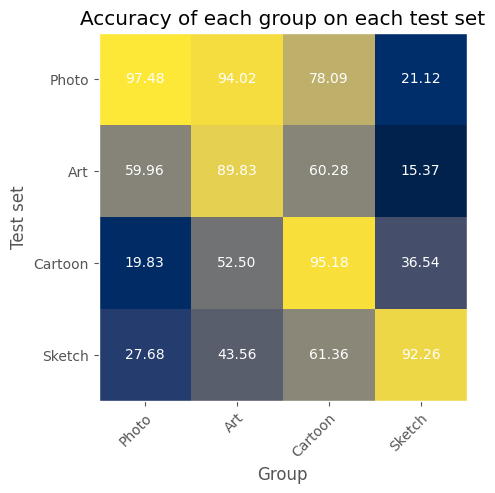

In [113]:
# load acc_matrix from PACS_acc_matrix.pkl
with open('PACS_acc_matrix.pkl', 'rb') as file:
    acc_matrix = pickle.load(file)

mean_matrix = np.mean(acc_matrix, axis=2)
std_matrix = np.std(acc_matrix, axis=2)

# make heatmap of test with colorbar and lava colormap
fig, ax = plt.subplots()
im = ax.imshow(mean_matrix, cmap='cividis')

# We want to show all ticks...
ax.set_xticks(np.arange(4))
ax.set_yticks(np.arange(4))
# ... and label them with the respective list entries
ax.set_xticklabels(['Photo', 'Art', 'Cartoon', 'Sketch'])
ax.set_yticklabels(['Photo', 'Art', 'Cartoon', 'Sketch'])

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(4):
    for j in range(4):
        text = ax.text(j, i, '{:.2f}'.format(mean_matrix[i, j]),
                       ha="center", va="center", color="w")

ax.set_title("Accuracy of each group on each test set")
fig.tight_layout()

# set xlabel
ax.set_xlabel('Group')
ax.set_ylabel('Test set')

# remove grid
ax.grid(False)
plt.show()
